# Predict the level of Problematic Internet Use Among Children and Adolescents

### Import Libraries and Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.datasets import load_iris

In [ ]:
# file paths
filePathTrain = r'D:\7th Semester\Data Mining\Mini-project\Dataset\train.csv'
filePathTest = r'D:\7th Semester\Data Mining\Mini-project\Dataset\test.csv'
filePathDict = r'D:\7th Semester\Data Mining\Mini-project\Dataset\data_dictionary.csv'

# Load data into data frames
train_data = pd.read_csv(filePathTrain)
test_data = pd.read_csv(filePathTest)
data_dictionary = pd.read_csv(filePathDict)

## 1. Introduction

*The primary objective of this project is to utilize our training data to predict the Severity Impairment Index (SII), a standardized metric used to assess the level of Problematic Internet Use (PIU).*

In [ ]:
print(f"The shape of the training DataFrame       : {train_data.shape}")
print(f"The shape of the test DataFrame           : {test_data.shape}")
print(f"The shape of the data dictionary DataFrame: {data_dictionary.shape}")

The shape of the training DataFrame       : (3960, 82)
The shape of the test DataFrame           : (20, 59)
The shape of the data dictionary DataFrame: (81, 6)


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

> The training dataset includes 3,960 records of children and adolescents, each with 81 features (excluding the ID column). Among the critical fields is the Parent-Child Internet Addiction Test (PCIAT) results. The target variable is derived from the `PCIAT_Total` field, scored out of 100.

> This setup provides two modeling options: we can predict the PCIAT Total directly and then convert it to the `Severity Impairment Index (SII)`, framing the task as a ***regression problem***, or we can focus on predicting the SII itself, framing it as a ***classification problem***.

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


> In the test dataset, none of the 22 PCIAT-related fields are available, including the target feature, resulting in a sample format with only **58 columns** compared to the 81 columns in the training data. Additionally, the test dataset contains only **20 samples**.

In [ ]:
print("Total number of missing training values: ", train_data.isna().sum().sum())

Total number of missing training values:  131717


## 2. Features
---

**Measurements from a variety of instruments**

1. **Demographics**: Information about the age and sex of participants.

2. **Internet Use**: The number of hours participants spend using a computer or the internet per day.

3. **Children's Global Assessment Scale**: A numeric scale used by mental health clinicians to assess the general functioning of youths under the age of 18.

4. **Physical Measures**: Data on participants' `blood pressure`, `heart rate`, `height`, `weight`, and `waist and hip measurements`.

5. **FitnessGram Vitals and Treadmill**: Measurements of cardiovascular fitness assessed using the NHANES treadmill protocol.

6. **FitnessGram Child**: A health-related physical fitness assessment measuring five parameters: `aerobic capacity`, `muscular strength`, `muscular endurance`, `flexibility`, and `body composition`.

7. **Bio-electric Impedance Analysis**: A measure of key body composition elements, including `BMI`, `fat percentage`, `muscle mass`, and `water content`.

8. **Physical Activity Questionnaire**: Information about children's participation in vigorous physical activities over the past 7 days.

9. **Sleep Disturbance Scale**: A scale used to categorize sleep disorders in children.

10. **Actigraphy**: An objective measure of ecological physical activity collected using a research-grade biotracker.

11. **Parent-Child Internet Addiction Test (PCIAT)**: A 20-item scale measuring characteristics and behaviors associated with compulsive internet use, including compulsivity, escapism, and dependency.

  >**PCIAT_Total**: This field summarizes the results of the PCIAT test. The target variable, `SII`, is derived from this field, with categories as follows:
      - 0: None
      - 1: Mild
      - 2: Moderate
      - 3: Severe

12. **Participant Identifier**: Each participant is assigned a unique identifier (`id`).

>**Season**: *For each set of measurements, there is a 'season' feature indicating the season of the year when the measurements were carried out. This is one of the primary categorical features in the dataset and can be easily preprocessed.*

In [ ]:
data_dictionary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Instrument    81 non-null     object
 1   Field         81 non-null     object
 2   Description   81 non-null     object
 3   Type          81 non-null     object
 4   Values        42 non-null     object
 5   Value Labels  32 non-null     object
dtypes: object(6)
memory usage: 3.9+ KB


In [ ]:
unique_instruments = data_dictionary['Instrument'].unique()
unique_instruments

array(['Identifier', 'Demographics', "Children's Global Assessment Scale",
       'Physical Measures', 'FitnessGram Vitals and Treadmill',
       'FitnessGram Child', 'Bio-electric Impedance Analysis',
       'Physical Activity Questionnaire (Adolescents)',
       'Physical Activity Questionnaire (Children)',
       'Parent-Child Internet Addiction Test', 'Sleep Disturbance Scale',
       'Internet Use'], dtype=object)

### Handling season feature in every measurement

In [ ]:
train_cat_columns = train_data.select_dtypes(exclude = 'number').columns

for season in train_cat_columns:
    train_data[season] = train_data[season].fillna(0)
    train_data[season] = train_data[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

<ipython-input-11-fb076cab1ff0>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data[season] = train_data[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})


### PCIAT Features

As noted, the 22 PCIAT features consist of responses to 20 questions (each scored out of 5), along with the total PCIAT score and the "season" in which the test was conducted. The SII target is derived from the total PCIAT score based on the following scale:

- 0–30: SII = 0
- 31–49: SII = 1
- 50–79: SII = 2
- 80–100: SII = 3

In [ ]:
print(f"Samples for Instrument: {unique_instruments[9]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[9]])

Samples for Instrument: Parent-Child Internet Addiction Test


,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


In [ ]:
PCIAT_cols = [val for val in train_data.columns[train_data.columns.str.contains('PCIAT')]]
print('Number of PCIAT features = ' , len(PCIAT_cols))

Number of PCIAT features =  22


In [ ]:
fig = px.scatter(train_data, x = 'PCIAT-PCIAT_Total', color = 'sii', marginal_x="box", title = 'PCIAT Total')
fig = fig.update_layout(yaxis_title="")
fig.update_yaxes(showticklabels=False)


> `The box plot visualization of the PCIAT Total scores reveals that many of the higher scores appear as outliers.`



In [ ]:
print(train_data[train_data['PCIAT-PCIAT_Total']<=30].sii.value_counts())
print(train_data[(train_data['PCIAT-PCIAT_Total']>30)
    & (train_data['PCIAT-PCIAT_Total']<50)].sii.value_counts())
print(train_data[(train_data['PCIAT-PCIAT_Total']>=50)
    & (train_data['PCIAT-PCIAT_Total']<80)].sii.value_counts())
print(train_data[train_data['PCIAT-PCIAT_Total']>=80].sii.value_counts())

train_data.sii.value_counts()

sii
0.0    1594
Name: count, dtype: int64
sii
1.0    730
Name: count, dtype: int64
sii
2.0    378
Name: count, dtype: int64
sii
3.0    34
Name: count, dtype: int64


,count
sii,
0.0,1594
1.0,730
2.0,378
3.0,34


In [ ]:
# Check if sii values are consistent within each PCIAT_Total score range
is_consistent = (
    (train_data[train_data['PCIAT-PCIAT_Total'] <= 30]['sii'] == 0).all() and
    (train_data[(train_data['PCIAT-PCIAT_Total'] > 30) & (train_data['PCIAT-PCIAT_Total'] < 50)]['sii'] == 1).all() and
    (train_data[(train_data['PCIAT-PCIAT_Total'] >= 50) & (train_data['PCIAT-PCIAT_Total'] < 80)]['sii'] == 2).all() and
    (train_data[train_data['PCIAT-PCIAT_Total'] >= 80]['sii'] == 3).all()
)

print("SII distribution is consistent with PCIAT_Total score ranges:", is_consistent)


SII distribution is consistent with PCIAT_Total score ranges: True


>This sii values are correctly distributed within the PCIAT-PCIAT_Total score intervals.

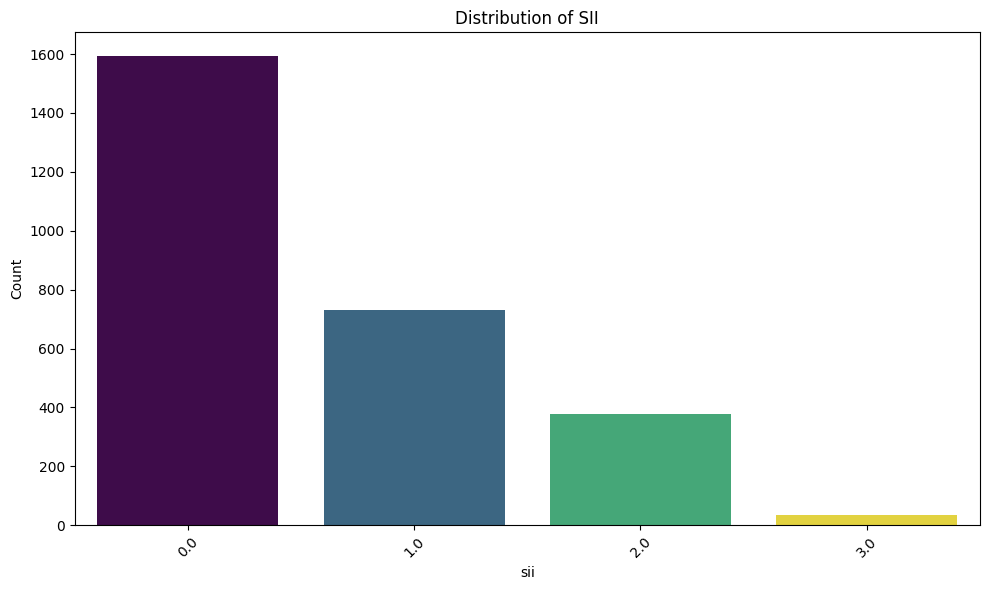

In [ ]:
# Plot the counts of each category in 'sii'
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='sii',  hue='sii', palette='viridis', legend=False)
plt.title('Distribution of SII')
plt.xlabel('sii')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*For analysis, I have decided to drop all individual PCIAT features from the dataset, except for the PCIAT Total score, which will be used as a regression target.*

In [ ]:
PCIAT_cols.remove('PCIAT-PCIAT_Total')
train_data = train_data.drop(columns = PCIAT_cols)

### Demographics Features
Information about age and sex of participants.

In [ ]:
print(f"Samples for Instrument: {unique_instruments[1]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[1]])

Samples for Instrument: Demographics


,Instrument,Field,Description,Type,Values,Value Labels
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"


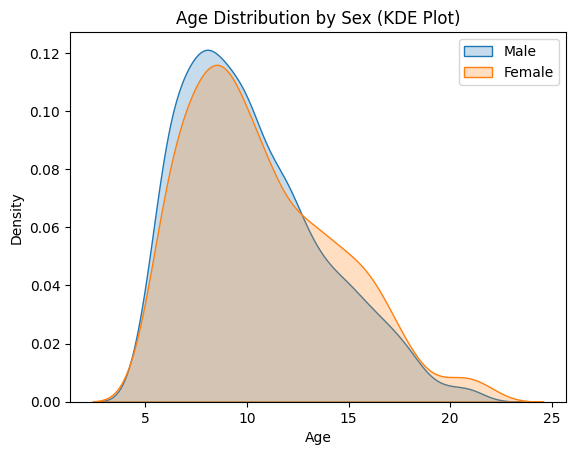

In [ ]:
# Separate the data by Sex
male_data = train_data[train_data['Basic_Demos-Sex'] == 0]['Basic_Demos-Age']
female_data = train_data[train_data['Basic_Demos-Sex'] == 1]['Basic_Demos-Age']

# Plot KDE for both
sns.kdeplot(male_data, label='Male', fill=True)
sns.kdeplot(female_data, label='Female', fill=True)

# Customize the plot
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution by Sex (KDE Plot)')
plt.legend()
plt.show()

### Internet Use
Number of hours of using computer/internet per day.

In [ ]:
print(f"Samples for Instrument: {unique_instruments[11]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[11]])

Samples for Instrument: Internet Use


,Instrument,Field,Description,Type,Values,Value Labels
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
80,Internet Use,PreInt_EduHx-computerinternet_hoursday,Hours of using computer/internet,categorical int,"0,1,2,3","0=Less than 1h/day, 1=Around 1h/day, 2=Around ..."


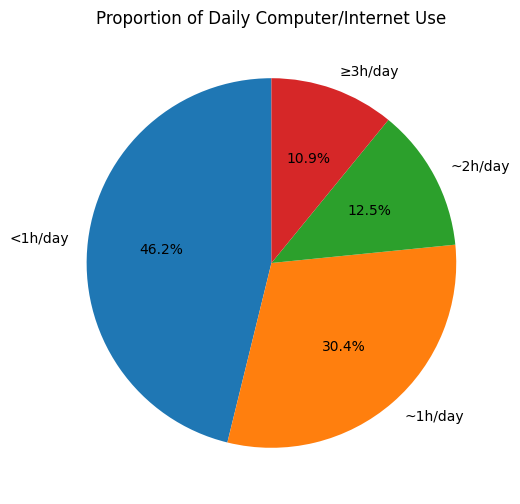

In [ ]:
# Count the frequency of each category
usage_counts = train_data['PreInt_EduHx-computerinternet_hoursday'].value_counts()

# Plot a pie chart
usage_counts.plot.pie(
    labels=['<1h/day', '~1h/day', '~2h/day', '≥3h/day'],
    autopct='%1.1f%%',
    startangle=90,
    figsize=(6, 6)
)

# Customize the plot
plt.title('Proportion of Daily Computer/Internet Use')
plt.ylabel('')  # Hide the y-label for aesthetics
plt.show()

### Children's Global Assessment Scale
Numeric scale used by mental health clinicians to rate the general functioning of youths under the age of 18.

In [ ]:
print(f"Samples for Instrument: {unique_instruments[2]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[2]])

Samples for Instrument: Children's Global Assessment Scale


,Instrument,Field,Description,Type,Values,Value Labels
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN


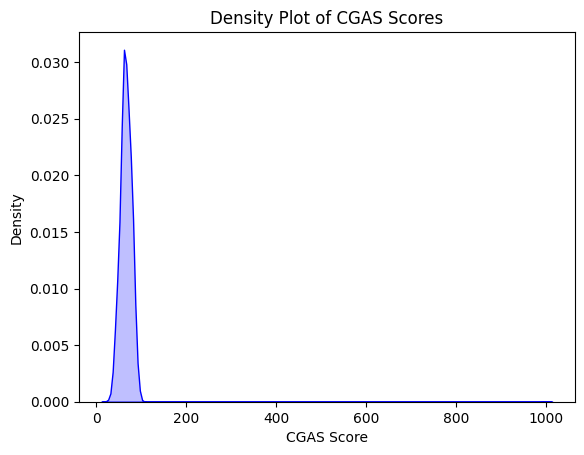

In [ ]:
sns.kdeplot(train_data['CGAS-CGAS_Score'], fill=True, color='blue')

# Customize the plot
plt.xlabel('CGAS Score')
plt.ylabel('Density')
plt.title('Density Plot of CGAS Scores')
plt.show()

### Physical Measures

In [ ]:
print(f"Samples for Instrument: {unique_instruments[3]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[3]])

Samples for Instrument: Physical Measures


,Instrument,Field,Description,Type,Values,Value Labels
6,Physical Measures,Physical-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical Measures,Physical-BMI,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical Measures,Physical-Height,Height (in),float,NaN,NaN
9,Physical Measures,Physical-Weight,Weight (lbs),float,NaN,NaN
10,Physical Measures,Physical-Waist_Circumference,Waist circumference (in),int,NaN,NaN
11,Physical Measures,Physical-Diastolic_BP,Diastolic BP (mmHg),int,NaN,NaN
12,Physical Measures,Physical-HeartRate,Heart rate (beats/min),int,NaN,NaN
13,Physical Measures,Physical-Systolic_BP,Systolic BP (mmHg),int,NaN,NaN


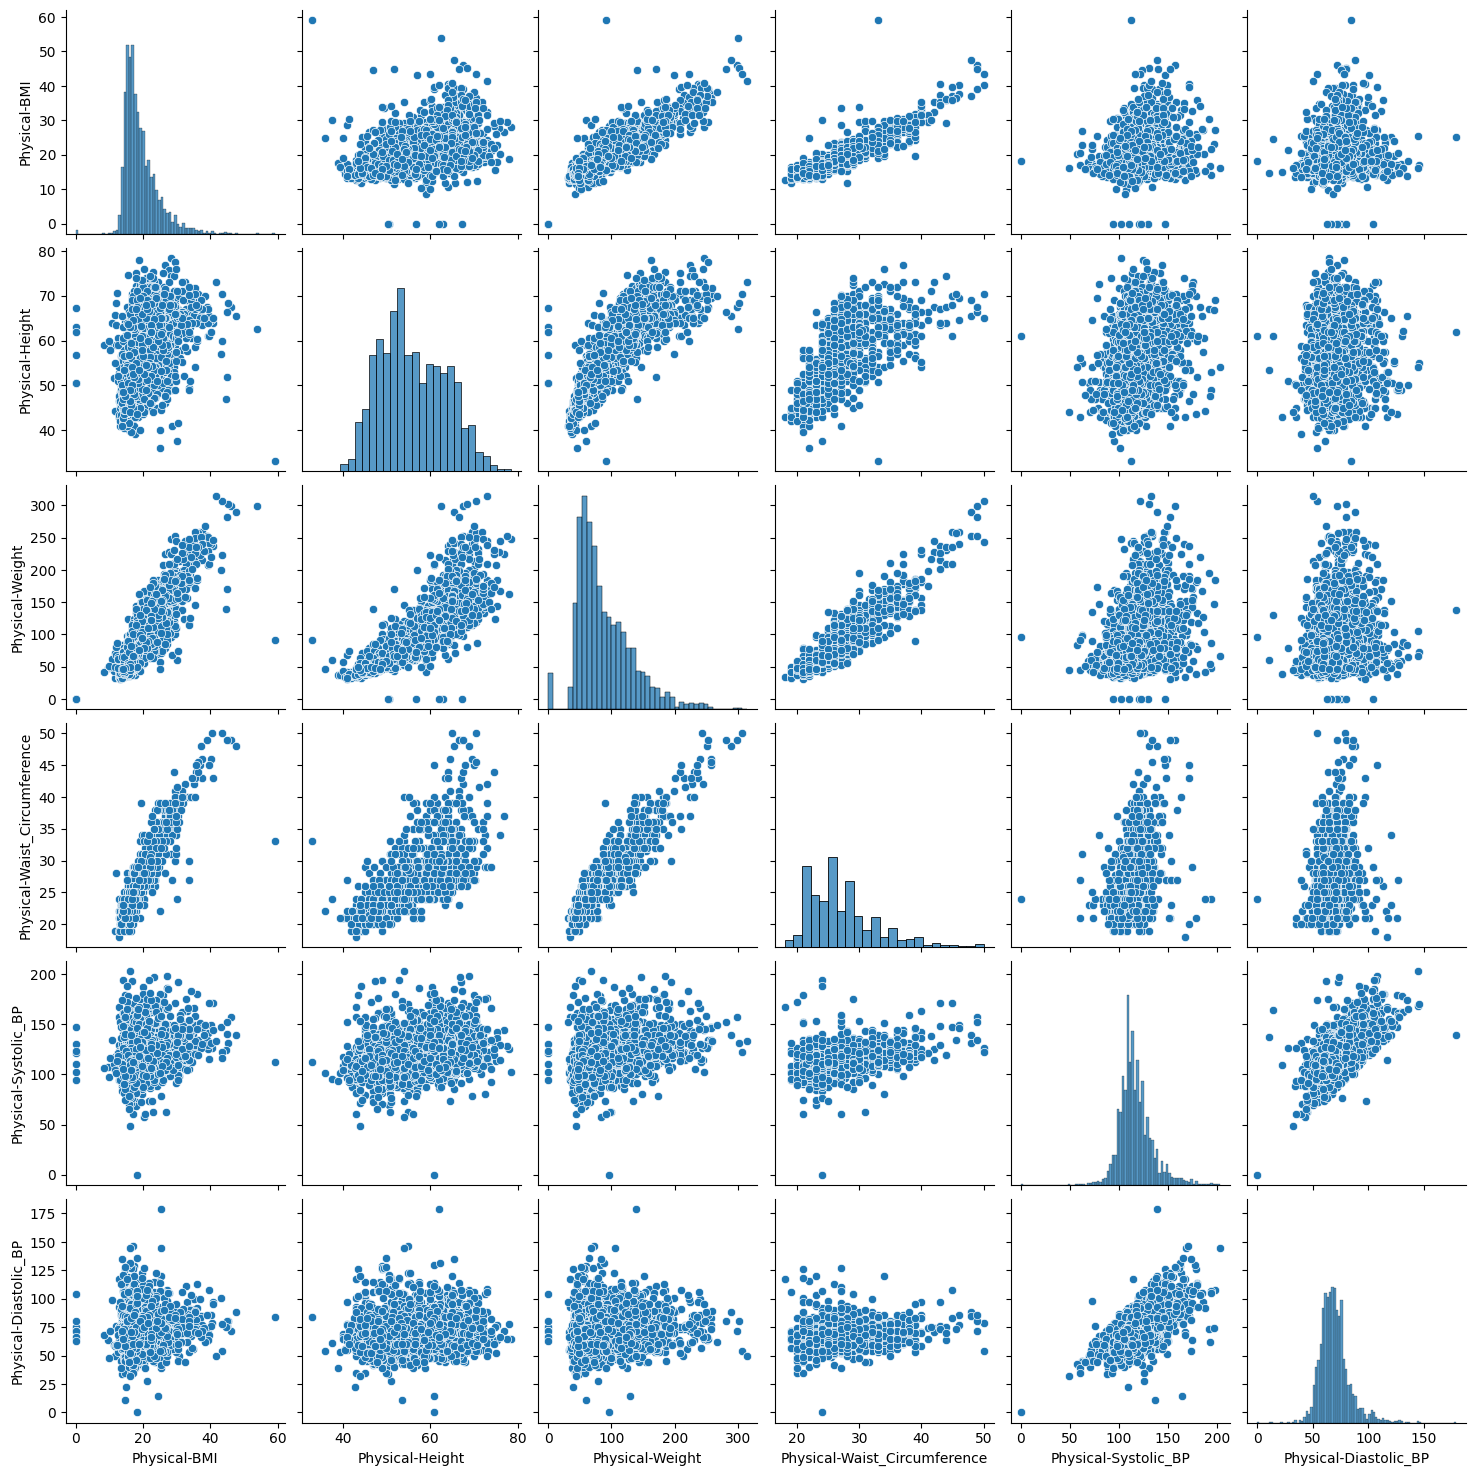

In [43]:
# Select relevant physical measures
physical_features = train_data[['Physical-BMI', 'Physical-Height', 'Physical-Weight',
                                'Physical-Waist_Circumference', 'Physical-Systolic_BP',
                                'Physical-Diastolic_BP']]

# Pair plot
sns.pairplot(physical_features)
plt.show()

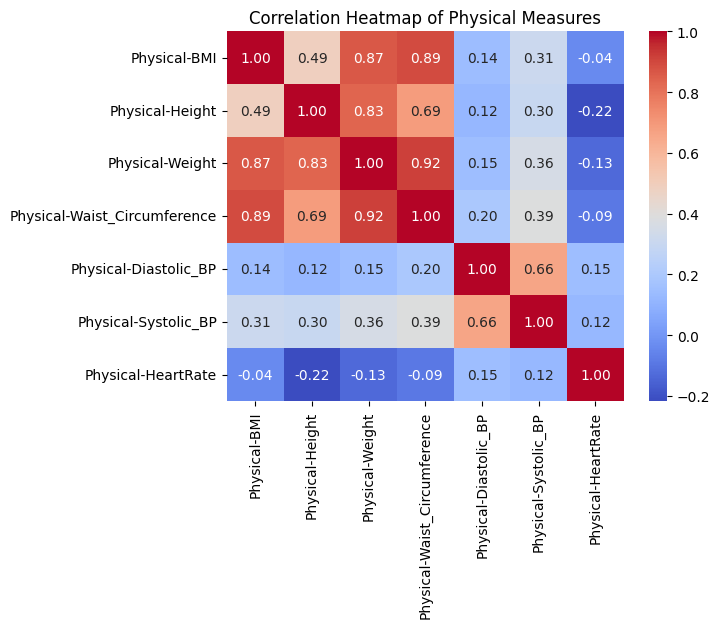

In [44]:
# Correlation matrix for physical measures
corr_matrix = train_data[['Physical-BMI', 'Physical-Height', 'Physical-Weight',
                          'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
                          'Physical-Systolic_BP', 'Physical-HeartRate']].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Physical Measures')
plt.show()

Here, we observe four high correlation values: 0.92, 0.89, 0.87, and 0.83. These correspond to the following feature pairs: Physical-Waist_Circumference and Physical-Weight, Physical-Waist_Circumference and Physical-BMI, Physical-Weight and Physical-BMI, and Physical-Weight and Physical-Height. Given these strong correlations, I have decided to remove Physical-Weight and Physical-Waist_Circumference to minimize redundancy and simplify the dataset.

### FitnessGram Vitals and Treadmill

In [ ]:
print(f"Samples for Instrument: {unique_instruments[4]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[4]])

Samples for Instrument: FitnessGram Vitals and Treadmill


,Instrument,Field,Description,Type,Values,Value Labels
14,FitnessGram Vitals and Treadmill,Fitness_Endurance-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
15,FitnessGram Vitals and Treadmill,Fitness_Endurance-Max_Stage,Maximum stage reached,int,NaN,NaN
16,FitnessGram Vitals and Treadmill,Fitness_Endurance-Time_Mins,Exact time completed: Minutes,int,NaN,NaN
17,FitnessGram Vitals and Treadmill,Fitness_Endurance-Time_Sec,Exact time completed: Seconds,int,NaN,NaN


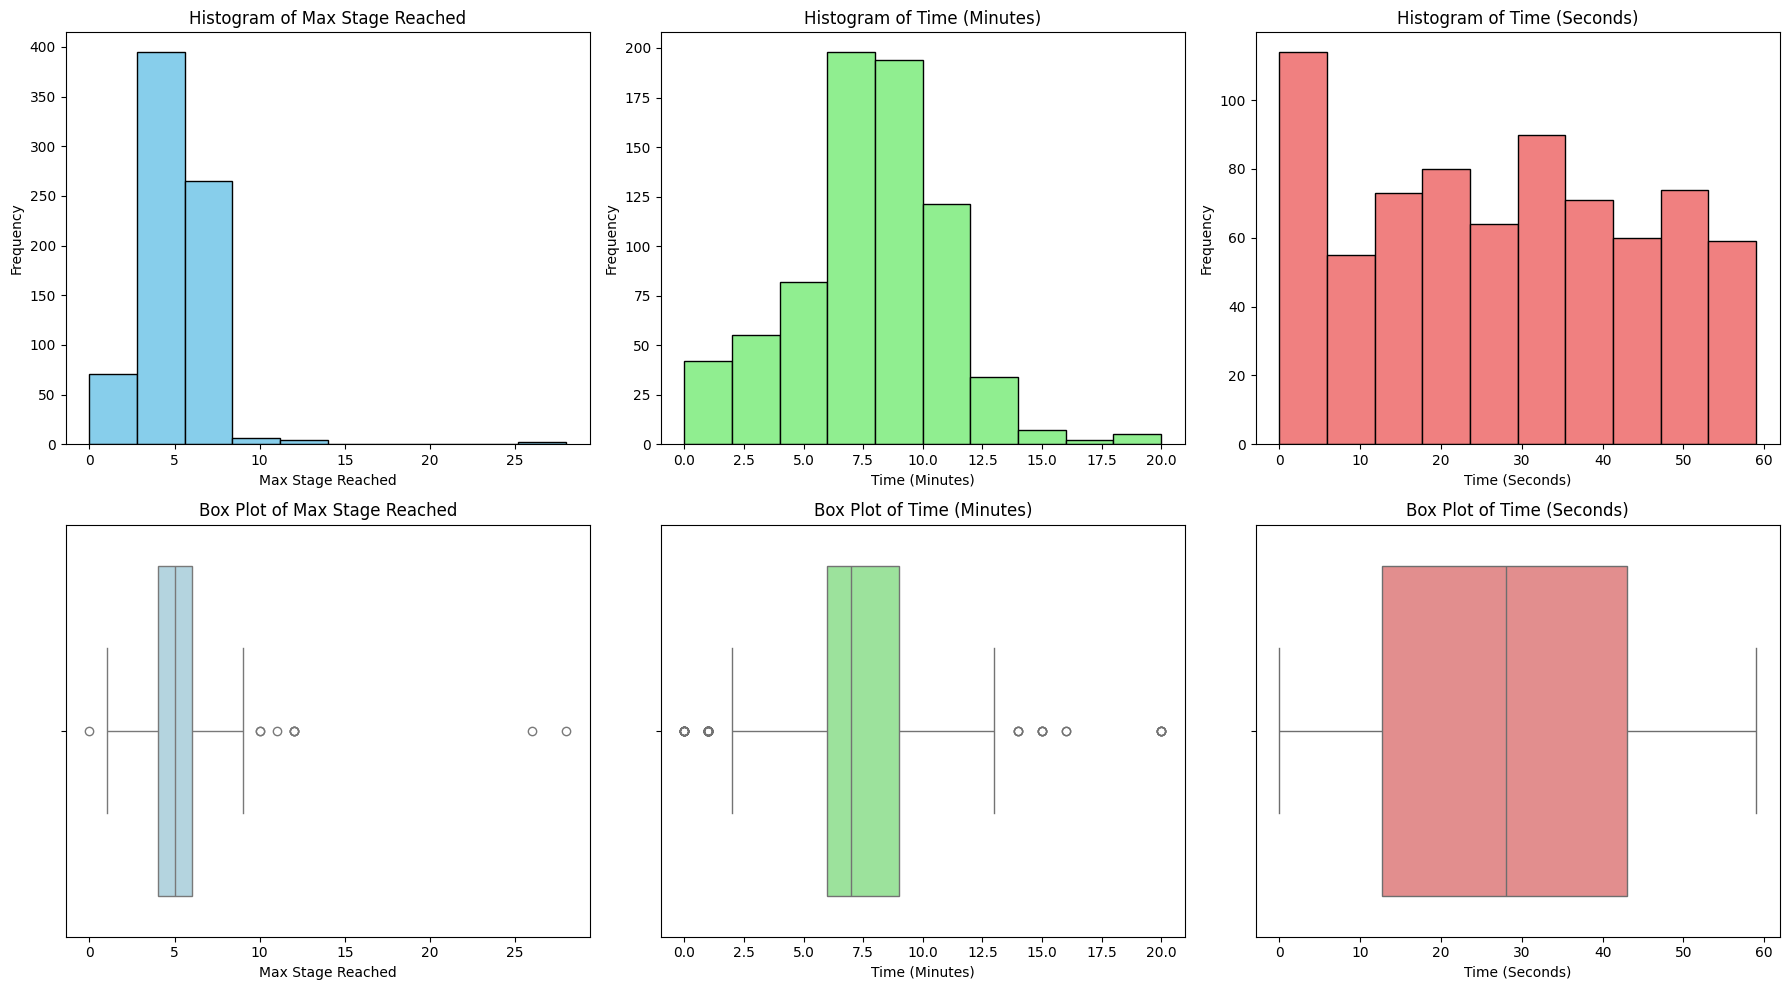

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plotting histograms
axes[0, 0].hist(train_data['Fitness_Endurance-Max_Stage'], bins=10, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histogram of Max Stage Reached')
axes[0, 0].set_xlabel('Max Stage Reached')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(train_data['Fitness_Endurance-Time_Mins'], bins=10, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Histogram of Time (Minutes)')
axes[0, 1].set_xlabel('Time (Minutes)')
axes[0, 1].set_ylabel('Frequency')

axes[0, 2].hist(train_data['Fitness_Endurance-Time_Sec'], bins=10, color='lightcoral', edgecolor='black')
axes[0, 2].set_title('Histogram of Time (Seconds)')
axes[0, 2].set_xlabel('Time (Seconds)')
axes[0, 2].set_ylabel('Frequency')

# Plotting box plots
sns.boxplot(x=train_data['Fitness_Endurance-Max_Stage'], ax=axes[1, 0], color='lightblue')
axes[1, 0].set_title('Box Plot of Max Stage Reached')
axes[1, 0].set_xlabel('Max Stage Reached')

sns.boxplot(x=train_data['Fitness_Endurance-Time_Mins'], ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Box Plot of Time (Minutes)')
axes[1, 1].set_xlabel('Time (Minutes)')

sns.boxplot(x=train_data['Fitness_Endurance-Time_Sec'], ax=axes[1, 2], color='lightcoral')
axes[1, 2].set_title('Box Plot of Time (Seconds)')
axes[1, 2].set_xlabel('Time (Seconds)')

# Adjust layout to make room for titles and labels
plt.tight_layout()
plt.show()

### FitnessGram Child

In [ ]:
print(f"Samples for Instrument: {unique_instruments[5]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[5]])

Samples for Instrument: FitnessGram Child


,Instrument,Field,Description,Type,Values,Value Labels
18,FitnessGram Child,FGC-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
19,FitnessGram Child,FGC-FGC_CU,Curl up total,int,NaN,NaN
20,FitnessGram Child,FGC-FGC_CU_Zone,Curl up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
21,FitnessGram Child,FGC-FGC_GSND,Grip Strength total (non-dominant),float,NaN,NaN
22,FitnessGram Child,FGC-FGC_GSND_Zone,Grip Strength fitness zone (non-dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
23,FitnessGram Child,FGC-FGC_GSD,Grip Strength total (dominant),float,NaN,NaN
24,FitnessGram Child,FGC-FGC_GSD_Zone,Grip Strength fitness zone (dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
25,FitnessGram Child,FGC-FGC_PU,Push-up total,int,NaN,NaN
26,FitnessGram Child,FGC-FGC_PU_Zone,Push-up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
27,FitnessGram Child,FGC-FGC_SRL,Sit & Reach total (left side),float,NaN,NaN


<ipython-input-47-c0226db931d4>:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-47-c0226db931d4>:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-47-c0226db931d4>:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




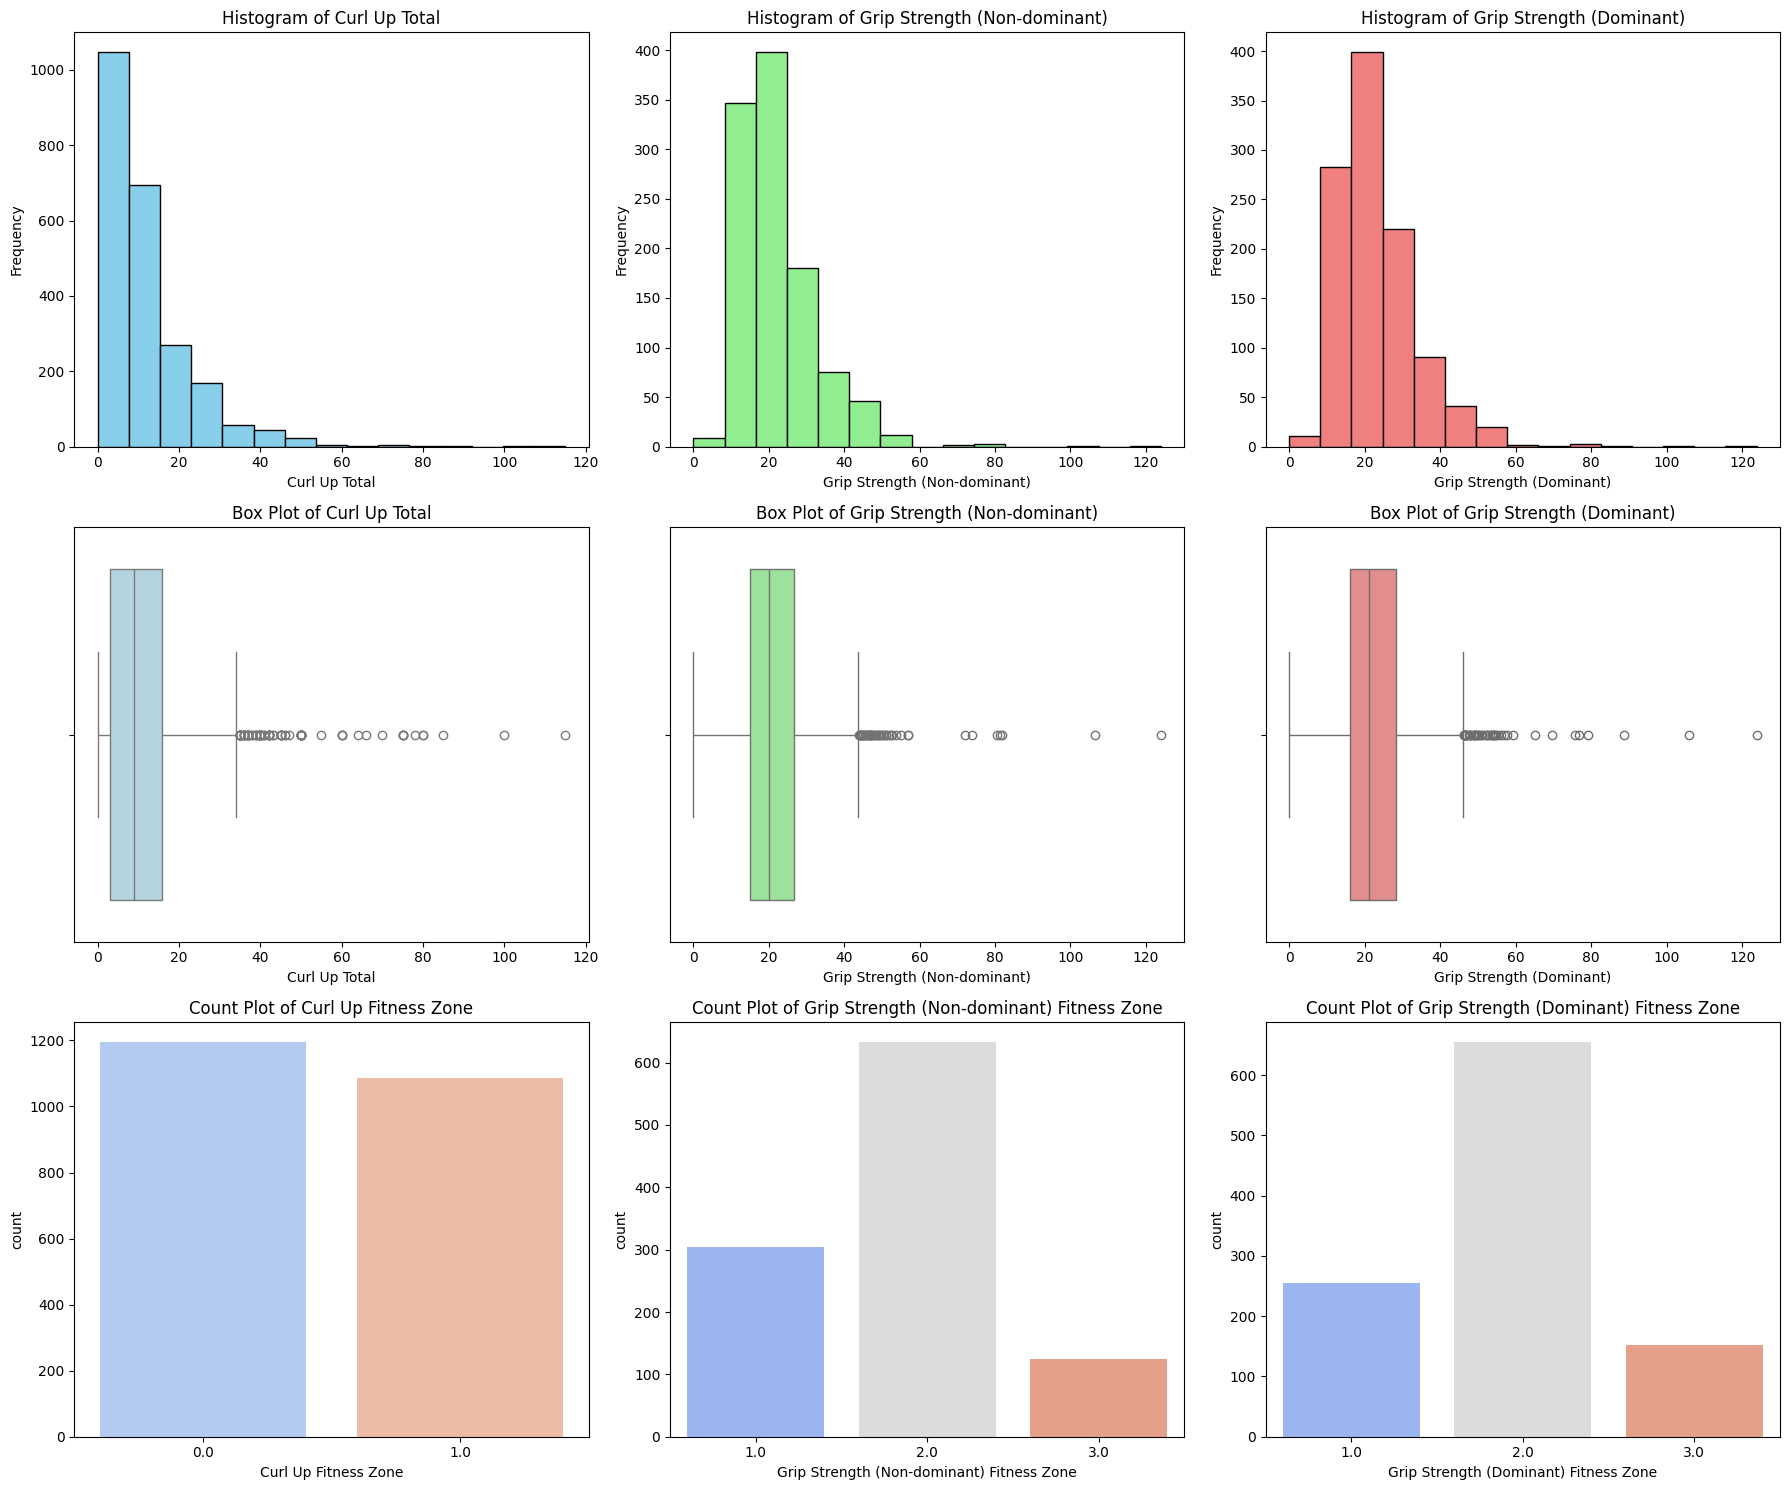

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Numeric Features Histograms
axes[0, 0].hist(train_data['FGC-FGC_CU'], bins=15, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histogram of Curl Up Total')
axes[0, 0].set_xlabel('Curl Up Total')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(train_data['FGC-FGC_GSND'], bins=15, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Histogram of Grip Strength (Non-dominant)')
axes[0, 1].set_xlabel('Grip Strength (Non-dominant)')
axes[0, 1].set_ylabel('Frequency')

axes[0, 2].hist(train_data['FGC-FGC_GSD'], bins=15, color='lightcoral', edgecolor='black')
axes[0, 2].set_title('Histogram of Grip Strength (Dominant)')
axes[0, 2].set_xlabel('Grip Strength (Dominant)')
axes[0, 2].set_ylabel('Frequency')

# Numeric Features Box Plots
sns.boxplot(x=train_data['FGC-FGC_CU'], ax=axes[1, 0], color='lightblue')
axes[1, 0].set_title('Box Plot of Curl Up Total')
axes[1, 0].set_xlabel('Curl Up Total')

sns.boxplot(x=train_data['FGC-FGC_GSND'], ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Box Plot of Grip Strength (Non-dominant)')
axes[1, 1].set_xlabel('Grip Strength (Non-dominant)')

sns.boxplot(x=train_data['FGC-FGC_GSD'], ax=axes[1, 2], color='lightcoral')
axes[1, 2].set_title('Box Plot of Grip Strength (Dominant)')
axes[1, 2].set_xlabel('Grip Strength (Dominant)')

# Categorical Features Count Plots (Bar Charts)
sns.countplot(x=train_data['FGC-FGC_CU_Zone'], ax=axes[2, 0], palette='coolwarm')
axes[2, 0].set_title('Count Plot of Curl Up Fitness Zone')
axes[2, 0].set_xlabel('Curl Up Fitness Zone')

sns.countplot(x=train_data['FGC-FGC_GSND_Zone'], ax=axes[2, 1], palette='coolwarm')
axes[2, 1].set_title('Count Plot of Grip Strength (Non-dominant) Fitness Zone')
axes[2, 1].set_xlabel('Grip Strength (Non-dominant) Fitness Zone')

sns.countplot(x=train_data['FGC-FGC_GSD_Zone'], ax=axes[2, 2], palette='coolwarm')
axes[2, 2].set_title('Count Plot of Grip Strength (Dominant) Fitness Zone')
axes[2, 2].set_xlabel('Grip Strength (Dominant) Fitness Zone')

# Adjust layout to make room for titles and labels
plt.tight_layout()
plt.show()

### Bio-electric Impedance Analysis

In [ ]:
print(f"Samples for Instrument: {unique_instruments[6]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[6]])

Samples for Instrument: Bio-electric Impedance Analysis


,Instrument,Field,Description,Type,Values,Value Labels
33,Bio-electric Impedance Analysis,BIA-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
34,Bio-electric Impedance Analysis,BIA-BIA_Activity_Level_num,Activity Level,categorical int,"1,2,3,4,5","1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=..."
35,Bio-electric Impedance Analysis,BIA-BIA_BMC,Bone Mineral Content,float,NaN,NaN
36,Bio-electric Impedance Analysis,BIA-BIA_BMI,Body Mass Index,float,NaN,NaN
37,Bio-electric Impedance Analysis,BIA-BIA_BMR,Basal Metabolic Rate,float,NaN,NaN
38,Bio-electric Impedance Analysis,BIA-BIA_DEE,Daily Energy Expenditure,float,NaN,NaN
39,Bio-electric Impedance Analysis,BIA-BIA_ECW,Extracellular Water,float,NaN,NaN
40,Bio-electric Impedance Analysis,BIA-BIA_FFM,Fat Free Mass,float,NaN,NaN
41,Bio-electric Impedance Analysis,BIA-BIA_FFMI,Fat Free Mass Index,float,NaN,NaN
42,Bio-electric Impedance Analysis,BIA-BIA_FMI,Fat Mass Index,float,NaN,NaN


### Physical Activity Questionnaire

In [ ]:
print(f"Samples for Instrument: {unique_instruments[7]} & {unique_instruments[8]}")
display(data_dictionary[(data_dictionary['Instrument'] == unique_instruments[7]) |
                        (data_dictionary['Instrument'] == unique_instruments[8])])

Samples for Instrument: Physical Activity Questionnaire (Adolescents) & Physical Activity Questionnaire (Children)


,Instrument,Field,Description,Type,Values,Value Labels
50,Physical Activity Questionnaire (Adolescents),PAQ_A-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
51,Physical Activity Questionnaire (Adolescents),PAQ_A-PAQ_A_Total,Activity Summary Score (Adolescents),float,NaN,NaN
52,Physical Activity Questionnaire (Children),PAQ_C-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
53,Physical Activity Questionnaire (Children),PAQ_C-PAQ_C_Total,Activity Summary Score (Children),float,NaN,NaN


### Sleep Disturbance Scale

In [ ]:
print(f"Samples for Instrument: {unique_instruments[10]}")
display(data_dictionary[data_dictionary['Instrument'] == unique_instruments[10]])

Samples for Instrument: Sleep Disturbance Scale


,Instrument,Field,Description,Type,Values,Value Labels
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN


### Severity Impairment Index


*Removes any rows in the train DataFrame where the sii column has missing (NaN) values.*

In [48]:
train_data = train_data.dropna(subset='sii')

## Correlations

Given the large number of available features, I decided to perform feature selection to assess its impact on the model. Here, I selected features with the strongest correlation to the PCIAT total score, discarding those with weaker correlations.

In [52]:
# Selecting only numeric columns for correlation
numeric_data = train_data.select_dtypes(include=['float64', 'int64'])
# Calculate correlation with PCIAT-PCIAT_Total
corr = numeric_data.corr()['PCIAT-PCIAT_Total'].sort_values(ascending=False)
corr = pd.DataFrame(corr)
corr.style.background_gradient(cmap='YlOrRd')

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
sii,0.899681
Physical-Height,0.420765
Basic_Demos-Age,0.409559
PreInt_EduHx-computerinternet_hoursday,0.374124
Physical-Weight,0.353048
Physical-Waist_Circumference,0.327013
FGC-FGC_CU,0.287494
BIA-BIA_BMI,0.248060
Physical-BMI,0.240858


In [55]:
selection = corr[(corr['PCIAT-PCIAT_Total']>.1) | (corr['PCIAT-PCIAT_Total']<-.1)]
selection = [val for val in selection.index]

In [56]:
selection

['PCIAT-PCIAT_Total',
 'sii',
 'Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'Physical-BMI',
 'SDS-SDS_Total_T',
 'SDS-SDS_Total_Raw',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'FGC-FGC_GSD',
 'Physical-Systolic_BP',
 'FGC-FGC_GSND',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'BIA-BIA_FFMI',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_SRL_Zone']

In [57]:
# Remove Specific Features
selection.remove('PCIAT-PCIAT_Total')
selection.remove('sii')
selection.remove('SDS-SDS_Total_Raw')

In [58]:
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'Physical-BMI',
 'SDS-SDS_Total_T',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'FGC-FGC_GSD',
 'Physical-Systolic_BP',
 'FGC-FGC_GSND',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'BIA-BIA_FFMI',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_SRL_Zone']

## Missing Values

In [59]:
null = train_data.isna().sum().sort_values(ascending = False).head(46)
null = pd.DataFrame(null)
null = null.rename(columns= {0:'Missing'})
null.style.background_gradient(cmap='YlOrRd')

,Missing
PAQ_A-PAQ_A_Total,2373
Physical-Waist_Circumference,2253
Fitness_Endurance-Time_Sec,2008
Fitness_Endurance-Time_Mins,2008
Fitness_Endurance-Max_Stage,2005
FGC-FGC_GSD_Zone,1872
FGC-FGC_GSND_Zone,1872
FGC-FGC_GSD,1865
FGC-FGC_GSND,1864
PAQ_C-PAQ_C_Total,1296


In [60]:
half_missing = [val for val in train_data.columns[train_data.isnull().sum()>len(train_data)/2]]
half_missing

['Physical-Waist_Circumference',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'FGC-FGC_GSND',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD',
 'FGC-FGC_GSD_Zone',
 'PAQ_A-PAQ_A_Total']

In [61]:
selection = [i for i in selection if i not in half_missing]
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'Physical-BMI',
 'SDS-SDS_Total_T',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'Physical-Systolic_BP',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'BIA-BIA_FFMI',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_SRL_Zone']

In [62]:
describe = train_data[selection].describe().T
describe = describe[['min','max']].sort_index()
describe.style.background_gradient(cmap='YlOrRd')

,min,max
BIA-BIA_BMI,0.048267,48.375400
BIA-BIA_FFMI,7.864850,217.771000
BIA-BIA_Frame_num,1.000000,3.000000
Basic_Demos-Age,5.000000,22.000000
FGC-FGC_CU,0.000000,115.000000
FGC-FGC_PU,0.000000,51.000000
FGC-FGC_SRL_Zone,0.000000,1.000000
FGC-FGC_SRR_Zone,0.000000,1.000000
FGC-FGC_TL,0.000000,21.000000
PAQ_A-Season,0.000000,4.000000


In [63]:
scaler = MinMaxScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data[selection]),
                                  columns=selection,
                                  index=train_data.index)

In [64]:
# Get descriptive statistics for the scaled data
scaled_describe = train_data_scaled.describe().T[['count', 'min', 'max']].sort_index()

# Display the result
scaled_describe.style.background_gradient(cmap='YlOrRd')

,count,min,max
BIA-BIA_BMI,1813.000000,0.000000,1.000000
BIA-BIA_FFMI,1813.000000,0.000000,1.000000
BIA-BIA_Frame_num,1813.000000,0.000000,1.000000
Basic_Demos-Age,2736.000000,0.000000,1.000000
FGC-FGC_CU,1919.000000,0.000000,1.000000
FGC-FGC_PU,1909.000000,0.000000,1.000000
FGC-FGC_SRL_Zone,1877.000000,0.000000,1.000000
FGC-FGC_SRR_Zone,1879.000000,0.000000,1.000000
FGC-FGC_TL,1919.000000,0.000000,1.000000
PAQ_A-Season,2736.000000,0.000000,1.000000


In [65]:
X = train_data[selection]
test = test_data[selection]
y = train_data.sii

In [103]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Physical-Height                         2530 non-null   float64
 1   Basic_Demos-Age                         2736 non-null   int64  
 2   PreInt_EduHx-computerinternet_hoursday  2654 non-null   float64
 3   Physical-Weight                         2572 non-null   float64
 4   FGC-FGC_CU                              1919 non-null   float64
 5   BIA-BIA_BMI                             1813 non-null   float64
 6   Physical-BMI                            2527 non-null   float64
 7   SDS-SDS_Total_T                         2525 non-null   float64
 8   PAQ_A-Season                            2736 non-null   int64  
 9   FGC-FGC_PU                              1909 non-null   float64
 10  BIA-BIA_Frame_num                       1813 non-null   float64
 

In [73]:
X.isnull().sum()

,0
Physical-Height,206
Basic_Demos-Age,0
PreInt_EduHx-computerinternet_hoursday,82
Physical-Weight,164
FGC-FGC_CU,817
BIA-BIA_BMI,923
Physical-BMI,209
SDS-SDS_Total_T,211
PAQ_A-Season,0
FGC-FGC_PU,827


In [66]:
X.shape

(2736, 17)

In [69]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (2188, 17)
X_val shape: (548, 17)
y_train shape: (2188,)
y_val shape: (548,)


## Selected Features

## XGBoost

In [85]:
model_xgboost = xgb.XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=len(y.unique()),  # Number of classes in your target variable
    eval_metric='mlogloss',  # Logarithmic loss for multi-class classification
    random_state=42
)

# Train the model
model_xgboost.fit(X_train, y_train)

# Make predictions
y_pred = model_xgboost.predict(X_val)
y_pred_train = model_xgboost.predict(X_train)

# Evaluate the model's performance on the validation set
accuracy_val = accuracy_score(y_val, y_pred)
accuracy_train = accuracy_score(y_train, y_pred_train)

# Classification report for precision, recall, and F1 score
clf_report = classification_report(y_val, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

In [91]:
# Print results
print(f"Train Accuracy: {accuracy_train}")
print(f"Validation Accuracy: {accuracy_val}")
print("\nClassification Report:\n", clf_report)
print("\nConfusion Matrix:\n", conf_matrix)

Train Accuracy: 0.9917733089579525
Validation Accuracy: 0.6167883211678832

Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.85      0.78       336
         1.0       0.36      0.37      0.36       131
         2.0       0.19      0.07      0.10        72
         3.0       1.00      0.11      0.20         9

    accuracy                           0.62       548
   macro avg       0.57      0.35      0.36       548
weighted avg       0.58      0.62      0.58       548


Confusion Matrix:
 [[284  41  11   0]
 [ 73  48  10   0]
 [ 29  38   5   0]
 [  2   6   0   1]]


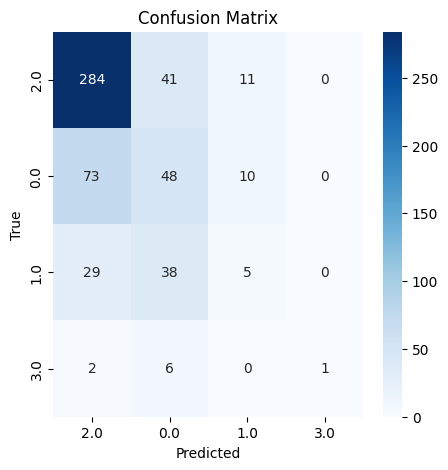

In [87]:
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

change parameters for XGBoost

In [97]:
# Set model parameters for XGBoost
params = {
    'max_depth': 3,
    'n_estimators': 202,
    'learning_rate': 0.07956777025142073,
    'subsample': 0.8197358255094112,
    'colsample_bytree': 0.645036755035947
}
# Initialize the XGBoost classifier with the given parameters
clf = xgb.XGBClassifier(**params)

In [98]:
# Define the custom quadratic weighted kappa scorer
def quadratic_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Create the kappa scorer
kappa_scorer = make_scorer(quadratic_kappa)

# Perform cross-validation and evaluate using the quadratic weighted kappa score
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=kappa_scorer)

# Print the results: QWK scores for each fold and the mean QWK score
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

QWK Scores: [0.29320382 0.4135213  0.31642188 0.34673274 0.30450232]
Mean QWK Score: 0.3348764135666515


In [100]:
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_val = accuracy_score(y_val, y_pred_val)
clf_report_val = classification_report(y_val, y_pred_val)
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

In [101]:
# Print the results
print("\nTrain Accuracy:", accuracy_train)
print("Validation Accuracy:", accuracy_val)
print("\nValidation Classification Report:")
print(clf_report_val)
print("\nValidation Confusion Matrix:")
print(conf_matrix_val)


Train Accuracy: 0.779707495429616
Validation Accuracy: 0.6186131386861314

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.87      0.79       336
         1.0       0.32      0.29      0.31       131
         2.0       0.32      0.11      0.16        72
         3.0       1.00      0.11      0.20         9

    accuracy                           0.62       548
   macro avg       0.59      0.35      0.36       548
weighted avg       0.58      0.62      0.58       548


Validation Confusion Matrix:
[[292  39   5   0]
 [ 82  38  11   0]
 [ 31  33   8   0]
 [  0   7   1   1]]


In [102]:
# Get and sort feature importances
feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the feature importances
print("\nFeature Importances:")
print(feature_imp)


Feature Importances:
Basic_Demos-Age                           0.107312
PreInt_EduHx-computerinternet_hoursday    0.105591
SDS-SDS_Total_T                           0.074181
Physical-Height                           0.066824
Physical-Weight                           0.064558
FGC-FGC_CU                                0.062438
Physical-BMI                              0.051492
FGC-FGC_PU                                0.051205
FGC-FGC_SRR_Zone                          0.050598
PAQ_C-Season                              0.049476
BIA-BIA_BMI                               0.047777
PAQ_A-Season                              0.047720
BIA-BIA_FFMI                              0.046973
Physical-Systolic_BP                      0.045807
BIA-BIA_Frame_num                         0.044509
FGC-FGC_TL                                0.042335
FGC-FGC_SRL_Zone                          0.041204
dtype: float32


## Handle the missing values

In [118]:
from sklearn.impute import KNNImputer
X.replace('NaN', np.nan, inplace=True)
# KNN imputation for numeric features
knn_imputer = KNNImputer(n_neighbors=5)
X[['Physical-Height', 'Physical-Weight',
    'FGC-FGC_CU', 'BIA-BIA_BMI', 'Physical-BMI', 'SDS-SDS_Total_T',
    'FGC-FGC_PU', 'Physical-Systolic_BP', 'FGC-FGC_TL',
    'BIA-BIA_FFMI']] = knn_imputer.fit_transform(X[['Physical-Height', 'Physical-Weight', 'FGC-FGC_CU', 'BIA-BIA_BMI', 'Physical-BMI', 'SDS-SDS_Total_T',
                                                            'FGC-FGC_PU', 'Physical-Systolic_BP',
                                                            'FGC-FGC_TL', 'BIA-BIA_FFMI']])

# Impute missing values in categorical features with the mode (most frequent value)
imputer = SimpleImputer(strategy='most_frequent')
X[['PAQ_A-Season', 'PAQ_C-Season', 'PreInt_EduHx-computerinternet_hoursday',
  'FGC-FGC_SRR_Zone', 'FGC-FGC_SRL_Zone', 'BIA-BIA_Frame_num']] = imputer.fit_transform(X[['PAQ_A-Season', 'PAQ_C-Season' ,'PreInt_EduHx-computerinternet_hoursday',
                                                                                                         'FGC-FGC_SRR_Zone', 'FGC-FGC_SRL_Zone', 'BIA-BIA_Frame_num']])

<ipython-input-118-6fc8b54a22ce>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-118-6fc8b54a22ce>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-118-6fc8b54a22ce>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [119]:
X.isnull().sum()

,0
Physical-Height,0
Basic_Demos-Age,0
PreInt_EduHx-computerinternet_hoursday,0
Physical-Weight,0
FGC-FGC_CU,0
BIA-BIA_BMI,0
Physical-BMI,0
SDS-SDS_Total_T,0
PAQ_A-Season,0
FGC-FGC_PU,0


In [120]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

X_train: (2188, 17)
X_val: (548, 17)
y_train: (2188,)
y_val: (548,)


In [122]:
# Find rows with any NaN values
rows_with_nan = X[X.isna().any(axis=1)]
print("Rows with NaN values:")
rows_with_nan


Rows with NaN values:


,Physical-Height,Basic_Demos-Age,PreInt_EduHx-computerinternet_hoursday,Physical-Weight,FGC-FGC_CU,BIA-BIA_BMI,Physical-BMI,SDS-SDS_Total_T,PAQ_A-Season,FGC-FGC_PU,BIA-BIA_Frame_num,Physical-Systolic_BP,FGC-FGC_TL,PAQ_C-Season,BIA-BIA_FFMI,FGC-FGC_SRR_Zone,FGC-FGC_SRL_Zone


## Model training

In [125]:
# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
}

results = {
    'Model': [],
    'Train Accuracy': [],
    'Validation Accuracy': [],
    'Classification Report': [],
    'Confusion Matrix': []
}

# Loop through each model, fit it, and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    y_pred_train = model.predict(X_train)

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_val = accuracy_score(y_val, y_pred)

    clf_report = classification_report(y_val, y_pred, output_dict=True)

    # Store metrics in the results dictionary
    results['Model'].append(name)
    results['Train Accuracy'].append(accuracy_train)
    results['Validation Accuracy'].append(accuracy_val)
    results['Confusion Matrix'].append(confusion_matrix(y_val, y_pred))
    results['Classification Report'].append(clf_report)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-p

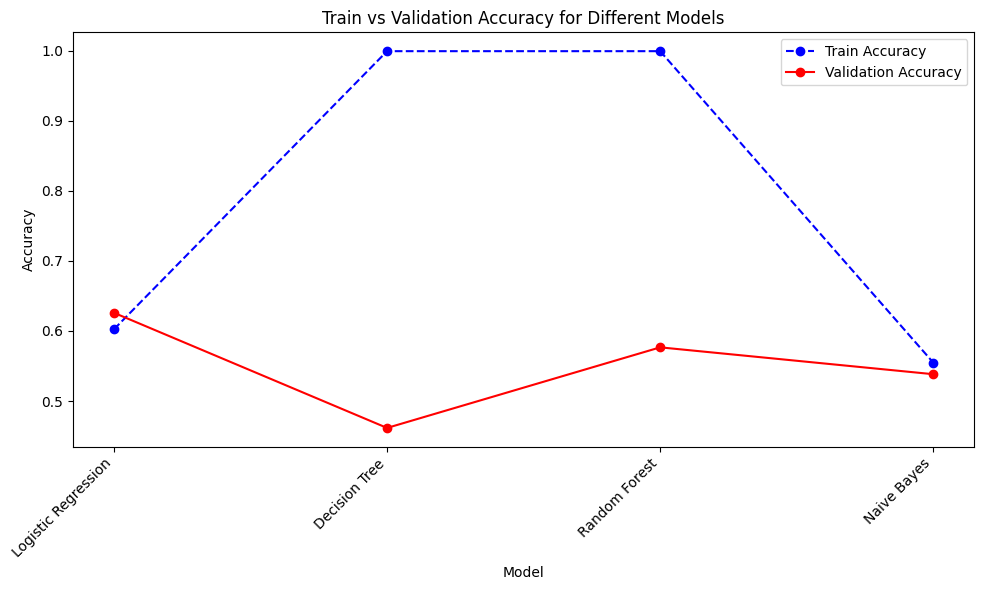

<Figure size 640x480 with 0 Axes>

In [126]:
results_df = pd.DataFrame(results)

# Plotting the results for training and validation accuracy
plt.figure(figsize=(10,6))
plt.plot(results_df['Model'], results_df['Train Accuracy'], label='Train Accuracy', marker='o', linestyle='--', color='blue')
plt.plot(results_df['Model'], results_df['Validation Accuracy'], label='Validation Accuracy', marker='o', linestyle='-', color='red')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy for Different Models')
plt.legend()
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [133]:
# Loop over the 'results' dictionary keys and print the results in a readable format
for i in range(len(results['Model'])):
    print(f"\n{'-'*50}")
    print(f"Model: {results['Model'][i]}")
    print(f"{'-'*50}")

    print(f"Accuracy on Training Data: {results['Train Accuracy'][i]:.4f}")
    print(f"Accuracy on Validation Data: {results['Validation Accuracy'][i]:.4f}")

    print("\nClassification Report:\n")
    for key in results['Classification Report'][i]:
        print(key)
        print(classification_report(results['Classification Report'][i][key], output_dict=False))
    
    print("\nConfusion Matrix:")
    print(results['Confusion Matrix'][i])

    print(f"{'-'*50}\n")



--------------------------------------------------
Model: Logistic Regression
--------------------------------------------------
Accuracy on Training Data: 0.6024
Accuracy on Validation Data: 0.6259

Classification Report:
 {'0.0': {'precision': 0.6951501154734411, 'recall': 0.8958333333333334, 'f1-score': 0.7828348504551366, 'support': 336.0}, '1.0': {'precision': 0.34177215189873417, 'recall': 0.20610687022900764, 'f1-score': 0.2571428571428571, 'support': 131.0}, '2.0': {'precision': 0.4117647058823529, 'recall': 0.19444444444444445, 'f1-score': 0.2641509433962264, 'support': 72.0}, '3.0': {'precision': 0.5, 'recall': 0.1111111111111111, 'f1-score': 0.18181818181818182, 'support': 9.0}, 'accuracy': 0.6259124087591241, 'macro avg': {'precision': 0.487171743313632, 'recall': 0.3518739397794742, 'f1-score': 0.3714867082031005, 'support': 548.0}, 'weighted avg': {'precision': 0.5702365867177733, 'recall': 0.6259124087591241, 'f1-score': 0.5791486416049856, 'support': 548.0}}

Confusion